<a href="https://colab.research.google.com/github/ashutoshrabia/EEGNet/blob/main/EEGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Visualization

In [ ]:
import numpy as np                                      # for dealing with data
from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering
import matplotlib.pyplot as plt                         # for plotting
import pandas
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle
from tensorflow.keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


In [ ]:
# Create filtering variables
fs = 200.0     # 200 Hz sampling rate
lowcut = 1.0   # 0.1 Hz is the lowest frequency we will pass
highcut = 40.0 # 30  Hz is the highest frequency we will pass.

In [ ]:
def butter_bandpass_filter(raw_data, fs, lowcut = 1.0, highcut =40.0, order = 5):
    '''
    The filter I want to apply to my raw eeg data.
    :raw_data (nparray): data you want to process
    :fs (float): sampling rate
    :lowcut (float, optional): lowest frequency we will pass
    :highcut (float, optional): highest frequency we will pass
    :order (int, optional): order of filter
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    filted_data = sosfiltfilt(sos, raw_data)
    return filted_data

In [ ]:
epoch_s = 0      # epoch starting time relative to stmulus in miliseconds
epoch_e = 700    # epoch ending time relative to stmulus in miliseconds
bl_s = 0         # baseline starting time relative to stmulus in miliseconds
bl_e = 100       # baseline ending time relative to stmulus in miliseconds


# number of mark per epoch
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

In [ ]:
train_subj_num = 16
test_subj_num = 10
stimulus_per_subj = 340
trial_per_subj = 5

channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
    'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
    'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'POz', 'P08', 'O1', 'O2']

In [ ]:
import pandas as pd
train_labels = pd.read_csv('/content/drive/MyDrive/TrainLabels.csv')
sample_train_data = pd.read_csv('/content/drive/MyDrive/Data_S02_Sess01.csv')

In [ ]:
train_labels

,IdFeedBack,Prediction
0,S02_Sess01_FB001,1
1,S02_Sess01_FB002,1
2,S02_Sess01_FB003,0
3,S02_Sess01_FB004,0
4,S02_Sess01_FB005,1
...,...,...
5435,S26_Sess05_FB096,1
5436,S26_Sess05_FB097,0
5437,S26_Sess05_FB098,0
5438,S26_Sess05_FB099,0


In [ ]:
train_list_arr = np.array(sorted(listdir('train')))
train_list_np = np.reshape(
    train_list_arr, (train_subj_num, trial_per_subj))
test_list_arr = np.array(sorted(listdir('test')))
test_list_np = np.reshape(
    test_list_arr, (test_subj_num, trial_per_subj))
print(train_list_np.shape, test_list_np.shape)

train_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
test_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
print(train_data_list.shape, test_data_list.shape)

In [ ]:
def generate_epoch(file_path, channels, fs, eeg_filter, stimulus_times=None, baseline=True,  epoch_s=0, epoch_e=700, bl_s=0, bl_e=100):
    # Generating epoch given csv file so that it should contain 'Time' column that represents timepoints, and the time should start from 0.
    # If your csv file does not have FeedBackEvent indicating the stimulus, you must pass stumulus_times.
    # Here we used a butter bandpass filter

    train_data = pd.read_csv(file_path)

    train_data.loc[:, 'Time'] = train_data.loc[:, 'Time']*1000
    raw_eeg = train_data[channels].values.T

    time_df = train_data['Time'].values
    train_data['index'] = train_data.index.values
    if stimulus_times is None:
        mark_indices = np.asarray(
            train_data[train_data['FeedBackEvent'] == 1].index).flatten()
    else:
        mark_indices = np.round(np.asarray(
            stimulus_times).flatten() * fs).astype(int)

    # We define the bounds of our epoch as well as our baseline

    # index in epoch_df where our baseline begins
    b_s = int((abs(epoch_s) + bl_s) * (fs / 1000))
    # index in epoch_df where our baseline ends
    b_e = int((abs(epoch_s) + bl_e) * (fs / 1000))

    # Let's calculate the length our epoch with our given sampling rate
    epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

    # The number of indices before marker we want
    e_s = int((epoch_s * (fs / 1000)))
    # The number of indices after marker we want
    e_e = int((epoch_e * (fs / 1000)))

    # Epoch the data
    final_epoch = np.empty((mark_indices.shape[0], epoch_len, 0), float)
    for channel in channels:
        epoch = np.zeros(shape=(int(mark_indices.shape[0]), epoch_len))
        raw_eeg = train_data[channel].values

        clean_eeg = eeg_filter(raw_eeg, fs, lowcut, highcut, 5)

        for i, mark_idx in enumerate(mark_indices):
            # grab the appropriate samples around the stimulus onset
            epoch[i, :] = clean_eeg[mark_idx + e_s: mark_idx + e_e]

        # Baseline correction
        if baseline:
            for i in range(0, int(epoch.shape[0])):
                epoch[i, :] = epoch[i, :] - np.mean(epoch[i, b_s:b_e])

        # stack epoch of each channel
        final_epoch = np.dstack((final_epoch, epoch))
    final_epoch = np.swapaxes(final_epoch, 1, 2)
    return final_epoch

In [ ]:
if not isfile("train_data.npy"):
    for training_participant_id in range(train_subj_num):
        subject_dir_list = train_list_np[training_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('train/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        train_data_list = np.vstack((train_data_list, subject_epoch))

    print('Epoched training data shape: ' + str(train_data_list.shape))

    for testing_participant_id in range(test_subj_num):
        subject_dir_list = test_list_np[testing_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('test/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        test_data_list = np.vstack((test_data_list, subject_epoch))

    print('Epoched testing data shape: ' + str(test_data_list.shape))

    np.save('train_data.npy', train_data_list)
    np.save('test_data.npy', test_data_list)

In [ ]:
train_data_list = np.load('/content/drive/MyDrive/train_data.npy')
test_data_list = np.load('/content/drive/MyDrive/test_data.npy')
print('Epoched training data shape: ' + str(train_data_list.shape))
print('Epoched testing data shape: ' + str(test_data_list.shape))

Epoched training data shape: (16, 340, 56, 140)
Epoched testing data shape: (10, 340, 56, 140)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint

# EEGNet


In [ ]:
def EEGNet(nb_classes, Chans = 64, Samples = 128,dropoutRate = 0.5, kernLength = 64, F1 = 8,D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (1, Chans, Samples))


    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((1, D), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.),
                                  data_format='channels_last')(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4), data_format='channels_last')(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8), data_format='channels_last')(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [ ]:
# Calculate the appropriate dimensions based on the total number of elements
total_elements1 = train_data_list.size
num_samples1 = 16 * 340
channels1 = 56
time_points1 = total_elements1 // (num_samples1 * channels1)

# Reshape the array with the calculated dimensions
X_train_valid = np.reshape(train_data_list, (num_samples1, channels1, time_points1))
print('Shape of X_train_valid:', X_train_valid.shape)
# Calculate the appropriate dimensions based on the total number of elements
total_elements2 = test_data_list.size
num_samples2 = 10 * 340
channels2 = 56
time_points2 = total_elements2 // (num_samples2 * channels2)

# Reshape the array with the calculated dimensions
X_test = np.reshape(test_data_list, (num_samples2, channels2, time_points2))
print('Shape of X_test_valid:', X_test.shape)


Shape of X_train_valid: (5440, 56, 140)
Shape of X_test_valid: (3400, 56, 140)


In [ ]:
#X_train_valid = np.reshape(train_data_list, (16*340, 56, 260))
Y_train_valid = pd.read_csv('/content/drive/MyDrive/TrainLabels.csv')['Prediction'].values
X_train = X_train_valid[1360:, :]
X_valid = X_train_valid[:1360, :]
y_train = Y_train_valid[1360:]
y_valid = Y_train_valid[:1360]

kernels, chans, samples = 1, 56, 140

X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_valid = X_valid.reshape(X_valid.shape[0], kernels, chans, samples)
X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

print(str(X_train.shape[0]) + ' train samples')
print(str(X_valid.shape[0]) + ' validation samples')
print(str(X_test.shape[0]) + ' test samples')

4080 train samples
1360 validation samples
3400 test samples


# Training Model

In [ ]:
model = EEGNet(nb_classes=2, Chans=chans, Samples=samples,
               dropoutRate=0.5, kernLength=100, F1=8, D=2, F2=16,
               dropoutType='Dropout')


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

numParams = model.count_params()

checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)


In [ ]:
weight_0 = 1/(len([y for y in Y_train_valid if y == 0]))
weight_1 = 1/(len([y for y in Y_train_valid if y == 1]))
class_weights = {0: weight_0, 1: weight_1}

fittedModel = model.fit(X_train, y_train, batch_size=34, epochs=10,verbose=2, validation_data=(X_valid, y_valid),callbacks=[checkpointer], class_weight=class_weights)


Epoch 1/10

Epoch 1: val_loss did not improve from inf
120/120 - 16s - loss: 2.5816e-04 - accuracy: 0.5400 - val_loss: nan - val_accuracy: 0.2368 - 16s/epoch - 137ms/step
Epoch 2/10

Epoch 2: val_loss did not improve from inf
120/120 - 13s - loss: 2.4935e-04 - accuracy: 0.5600 - val_loss: nan - val_accuracy: 0.2147 - 13s/epoch - 105ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from inf
120/120 - 14s - loss: 2.4307e-04 - accuracy: 0.5885 - val_loss: nan - val_accuracy: 0.2382 - 14s/epoch - 113ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from inf
120/120 - 12s - loss: 2.4158e-04 - accuracy: 0.5934 - val_loss: nan - val_accuracy: 0.2566 - 12s/epoch - 98ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from inf
120/120 - 19s - loss: 2.3815e-04 - accuracy: 0.6213 - val_loss: nan - val_accuracy: 0.2147 - 19s/epoch - 159ms/step
Epoch 6/10

Epoch 6: val_loss did not improve from inf
120/120 - 12s - loss: 2.3573e-04 - accuracy: 0.6140 - val_loss: nan - val_accuracy: 0.2235 

In [ ]:
_, accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print('Accuracy: {:.2f}%'.format(accuracy * 100))


Accuracy: 23.82%


In [ ]:
y_pred_proba = model.predict(X_test)

# Get the true labels (assuming y_test is one-hot encoded)
y_test_true = np.argmax(y_test, axis=1)

# Get the probabilities for the positive class (assuming binary classification)
y_pred_proba_pos = y_pred_proba[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_true, y_pred_proba_pos)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc}')

107/107 [==============================] - 2s 21ms/step


NameError: name 'y_test' is not defined

In [ ]:
y_pred_proba = model.predict(X_valid)

# Get the true labels (assuming y_test is one-hot encoded)
y_test_true = np.argmax(y_valid)

# Get the probabilities for the positive class (assuming binary classification)
y_pred_proba_pos = y_pred_proba[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_true, y_pred_proba_pos)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc}')

InvalidArgumentError: Graph execution error:

Detected at node model_5/batch_normalization/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-48-d54cb847bb81>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 979, in _fused_batch_norm_inference

convolution input must be 4-dimensional: [32,56,140]
	 [[{{node model_5/batch_normalization/FusedBatchNormV3}}]] [Op:__inference_predict_function_124170]

X_test shape: (3400, 1, 56, 140)
Y_test shape: (3400,)
Y_test_cat shape: (3400, 4)
107/107 [==============================] - 2s 21ms/step
Y_pred_prob shape: (3400, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


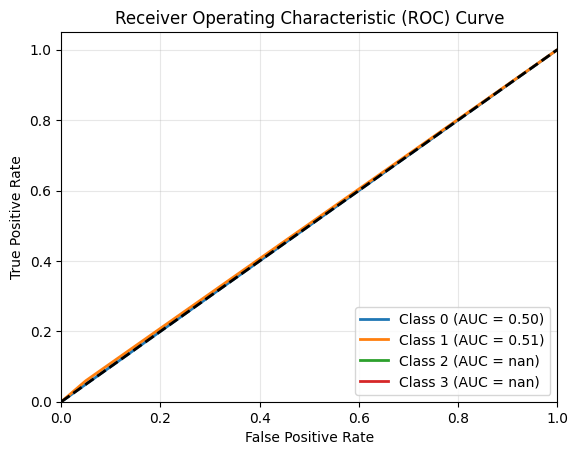

In [ ]:
X_test = np.reshape(test_data_list, (-1, 1, test_data_list.shape[2], test_data_list.shape[3]))


# Ensure Y_test has the correct number of samples
Y_test = Y_train_valid[:X_test.shape[0]]

# Convert to categorical
Y_test_cat = to_categorical(Y_test, num_classes=4)

# Print shapes for diagnostics
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"Y_test_cat shape: {Y_test_cat.shape}")

# Get the predicted probabilities for the test set
Y_pred_prob = model.predict(X_test)
if np.any(np.isnan(Y_pred_prob)):
    print("Warning: NaN values found in predictions. Investigate model or data.")
    # Handle NaNs (e.g., replace with a default value)
    Y_pred_prob = np.nan_to_num(Y_pred_prob)
# Ensure Y_pred_prob has the correct shape
if Y_pred_prob.shape[1] == 1 and Y_pred_prob.shape[0] == X_test.shape[0]:
    # Assuming the model is not outputting the probabilities correctly
    # Recalculate or reshape as needed
    Y_pred_prob = np.tile(Y_pred_prob, (1, 4))
if Y_pred_prob.shape[1] == 2:
    Y_pred_prob_temp = np.zeros((Y_pred_prob.shape[0], 4))
    Y_pred_prob_temp[:, :2] = Y_pred_prob
    Y_pred_prob_temp[:, 2:] = 1 - Y_pred_prob
    Y_pred_prob = Y_pred_prob_temp

# Print the prediction shape for diagnostics
print(f"Y_pred_prob shape: {Y_pred_prob.shape}")

# Ensure the number of samples match
assert X_test.shape[0] == Y_test.shape[0] == Y_pred_prob.shape[0], "Number of samples must match"

# Initialize plot
plt.figure()

# Calculate ROC curve and AUC for each class
for i in range(4):
    fpr, tpr, _ = roc_curve(Y_test_cat[:, i], Y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal line for no-skill classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Show plot
plt.show()


# LSTM


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Layer
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K



# Calculate dimensions and reshape the arrays
num_samples1 = 16 * 340
channels1 = 56
time_points1 = train_data_list.size // (num_samples1 * channels1)
X_train_valid = np.reshape(train_data_list, (num_samples1, channels1, time_points1))

num_samples2 = 10 * 340
channels2 = 56
time_points2 = test_data_list.size // (num_samples2 * channels2)
X_test = np.reshape(test_data_list, (num_samples2, channels2, time_points2))

# Load labels
Y_train_valid = pd.read_csv('/content/drive/MyDrive/TrainLabels.csv')['Prediction'].values

# Split into training and validation sets
X_train = X_train_valid[1360:, :]
X_valid = X_train_valid[:1360, :]
y_train = Y_train_valid[1360:]
y_valid = Y_train_valid[:1360]

# Reshape data for CNN compatibility
kernels, chans, samples = 1, 56, 140
X_train = X_train.reshape(X_train.shape[0], chans, samples)
X_valid = X_valid.reshape(X_valid.shape[0], chans, samples)
X_test = X_test.reshape(X_test.shape[0], chans, samples)

print(f'{X_train.shape[0]} train samples')
print(f'{X_valid.shape[0]} validation samples')
print(f'{X_test.shape[0]} test samples')

# Convert labels to categorical if it's a classification problem
num_classes = len(np.unique(Y_train_valid))
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)


4080 train samples
1360 validation samples
3400 test samples


In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)


In [ ]:
# Define the LSTM model with attention
input_layer = Input(shape=(chans, samples))
lstm_layer = LSTM(64, return_sequences=True)(input_layer)
attention_layer = Attention()(lstm_layer)
output_layer = Dense(num_classes, activation='softmax')(attention_layer)

model2 = Model(inputs=input_layer, outputs=output_layer)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model2
model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid))

# Evaluate the model2
loss, accuracy = model2.evaluate(X_valid, y_valid)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/100
128/128 [==============================] - 12s 68ms/step - loss: 0.6287 - accuracy: 0.6591 - val_loss: 0.5436 - val_accuracy: 0.7574
Epoch 2/100
128/128 [==============================] - 10s 77ms/step - loss: 0.5612 - accuracy: 0.7130 - val_loss: 0.5681 - val_accuracy: 0.7331
Epoch 3/100
128/128 [==============================] - 5s 38ms/step - loss: 0.5223 - accuracy: 0.7488 - val_loss: 0.5539 - val_accuracy: 0.7404
Epoch 4/100
128/128 [==============================] - 5s 38ms/step - loss: 0.4883 - accuracy: 0.7733 - val_loss: 0.5811 - val_accuracy: 0.7221
Epoch 5/100
128/128 [==============================] - 7s 54ms/step - loss: 0.4570 - accuracy: 0.7968 - val_loss: 0.6046 - val_accuracy: 0.6985
Epoch 6/100
128/128 [==============================] - 5s 38ms/step - loss: 0.4282 - accuracy: 0.8211 - val_loss: 0.5861 - val_accuracy: 0.7301
Epoch 7/100
128/128 [==============================] - 7s 51ms/step - loss: 0.3964 - accuracy: 0.8380 - val_loss: 0.5755 - val_accurac

In [ ]:
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 56, 140)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 56, 64)            52480     
                                                                 
 attention_4 (Attention)     (None, 64)                120       
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 52730 (205.98 KB)
Trainable params: 52730 (205.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


43/43 [==============================] - 1s 19ms/step


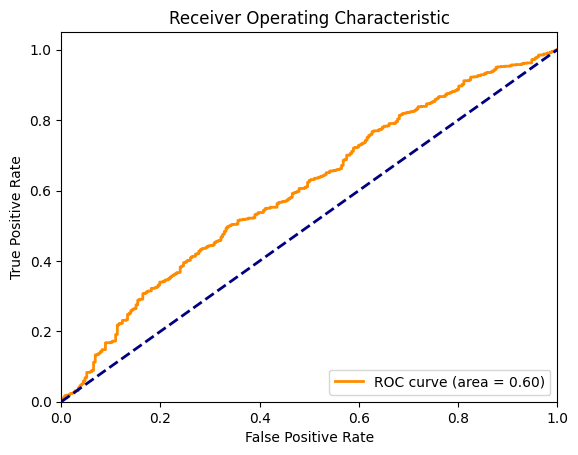

AUC: 0.6006858934893028


In [ ]:
y_pred_proba = model2.predict(X_valid)

# Get the true labels (assuming y_test is one-hot encoded)
y_test_true = np.argmax(y_valid, axis=1)

# Get the probabilities for the positive class (assuming binary classification)
y_pred_proba_pos = y_pred_proba[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_true, y_pred_proba_pos)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc}')

# Evaluation complete




In [ ]:
subj, trial, channel, sample = train_data_list.shape
X_train_valid = np.reshape(train_data_list, (-1, 1, channel, sample))
X_test = np.reshape(test_data_list, (-1, 1, channel, sample))

Y_train_valid = pd.read_csv('/content/drive/MyDrive/TrainLabels.csv')['Prediction'].values
split_thres = int(subj * trial * 0.25)
X_train, X_valid = X_train_valid[split_thres:, :], X_train_valid[:split_thres, :]
Y_train, Y_valid = Y_train_valid[split_thres:], Y_train_valid[:split_thres]

print('training data shape: ' + str(X_train.shape))
print('validation data shape: ' + str(X_valid.shape))
print('testing data shape: ' + str(X_test.shape))
print(Y_train.shape, Y_valid.shape)

training data shape: (4080, 1, 56, 140)
validation data shape: (1360, 1, 56, 140)
testing data shape: (3400, 1, 56, 140)
(4080,) (1360,)


In [ ]:
# Assuming your labels are in the range [0, 3] for 4 classes
Y_train = to_categorical(Y_train, num_classes=4)
Y_valid = to_categorical(Y_valid, num_classes=4)
class_weights = {i: 1 / np.sum(Y_train[:, i] == 1) for i in range(4)}
model = EEGNet(nb_classes=4, Chans=channel, Samples=sample)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.keras', verbose=1, save_best_only=True)

fittedModel = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=10,
    verbose=2,
    validation_data=(X_valid, Y_valid),
    callbacks=[checkpointer],
    class_weight=class_weights
)


<ipython-input-63-a8d389dcf5af>:4: RuntimeWarning: divide by zero encountered in scalar divide
  class_weights = {i: 1 / np.sum(Y_train[:, i] == 1) for i in range(4)}


ValueError: Exception encountered when calling layer "depthwise_conv2d_7" (type DepthwiseConv2D).

Negative dimension size caused by subtracting 56 from 1 for '{{node depthwise_conv2d_7/depthwise}} = DepthwiseConv2dNative[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1]](Placeholder, depthwise_conv2d_7/depthwise/ReadVariableOp)' with input shapes: [?,1,56,8], [56,1,8,2].

Call arguments received by layer "depthwise_conv2d_7" (type DepthwiseConv2D):
  • inputs=tf.Tensor(shape=(None, 1, 56, 8), dtype=float32)

In [ ]:
# Ensure data is in correct format (batch_size, channels, height, width)
X_train = np.transpose(X_train, (0, 3, 1, 2))  # (batch_size, channels, height, width)
X_valid = np.transpose(X_valid, (0, 3, 1, 2))  # (batch_size, channels, height, width)
X_test = np.transpose(X_test, (0, 3, 1, 2))    # (batch_size, channels, height, width)


In [ ]:

model = EEGNet(nb_classes=4, Chans=channel, Samples=sample)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.keras', verbose=1, save_best_only=True)


ValueError: Exception encountered when calling layer "depthwise_conv2d_8" (type DepthwiseConv2D).

Negative dimension size caused by subtracting 56 from 1 for '{{node depthwise_conv2d_8/depthwise}} = DepthwiseConv2dNative[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1]](Placeholder, depthwise_conv2d_8/depthwise/ReadVariableOp)' with input shapes: [?,1,56,8], [56,1,8,2].

Call arguments received by layer "depthwise_conv2d_8" (type DepthwiseConv2D):
  • inputs=tf.Tensor(shape=(None, 1, 56, 8), dtype=float32)

In [ ]:
print(X_train.shape, X_valid.shape)

(4080, 1, 56, 140) (1360, 1, 56, 140)


In [ ]:
from keras.utils import to_categorical

# Encode target labels
Y_train_cat = to_categorical(Y_train, num_classes=4)
Y_valid_cat = to_categorical(Y_valid, num_classes=4)

# Ensure the shape of Y_train_cat and Y_valid_cat
print('Y_train_cat shape:', Y_train_cat.shape)  # Should be (4080, 4)
print('Y_valid_cat shape:', Y_valid_cat.shape)  # Should be (1360, 4)


Y_train_cat shape: (4080, 4, 4)
Y_valid_cat shape: (1360, 4, 4)


In [ ]:
# Ensure data is in correct format (batch_size, height, width, channels)
X_train = np.transpose(X_train, (0, 2, 3, 1))  # (batch_size, height, width, channels)
X_valid = np.transpose(X_valid, (0, 2, 3, 1))  # (batch_size, height, width, channels)
X_test = np.transpose(X_test, (0, 2, 3, 1))    # (batch_size, height, width, channels)



In [ ]:
print(X_train.shape, X_valid.shape, X_test.shape)

(4080, 56, 140, 1) (1360, 56, 140, 1) (3400, 56, 140, 1)


In [ ]:
fittedModel = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=10,
    verbose=2,
    validation_data=(X_valid, Y_valid),
    callbacks=[checkpointer],
    class_weight=class_weights
)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 1, 56, 140), found shape=(None, 56, 140, 1)


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# Ensure data is in NHWC format
#X_train = np.transpose(X_train, (0, 2, 3, 1))
#X_valid = np.transpose(X_valid, (0, 2, 3, 1))
#X_test = np.transpose(X_test, (0, 2, 3, 1))

# One-Hot Encode Your Labels
Y_train = to_categorical(Y_train, num_classes=4)
Y_valid = to_categorical(Y_valid, num_classes=4)

# Adjust Class Weights
class_weights = {}
for i in range(4):
    count = np.sum(Y_train[:, i] == 1)
    if count > 0:
        class_weights[i] = 1 / count
    else:
        class_weights[i] = 1.0

# Define and Compile the Model
model = EEGNet(nb_classes=4, Chans=channel, Samples=sample)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define ModelCheckpoint Callback
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.keras', verbose=1, save_best_only=True)

# Train the Model
fittedModel = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=10,
    verbose=2,
    validation_data=(X_valid, Y_valid),
    callbacks=[checkpointer],
    class_weight=class_weights
)


In [ ]:


Y_train_cat = to_categorical(Y_train, num_classes=4)
Y_valid_cat = to_categorical(Y_valid, num_classes=4)

# Flatten the training data for StratifiedKFold
n_samples = X_train.shape[0]
X_train_flat = X_train.reshape(n_samples, -1)

# Initialize StratifiedKFold
n_splits = 2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Placeholder for storing fold results
fold_accuracies = []

for fold, (train_index, valid_index) in enumerate(skf.split(X_train_flat, Y_train)):
    print(f"Training fold {fold + 1}/{n_splits}...")

    # Split data
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    Y_train_fold, Y_valid_fold = Y_train_cat[train_index], Y_train_cat[valid_index]
    X_train_fold = np.transpose(X_train_fold, (0, 3, 1, 2))
    X_valid_fold = np.transpose(X_valid_fold, (0, 3, 1, 2))

    # Define the EEGNet model
    model = EEGNet(nb_classes=4, Chans=channel, Samples=sample)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define the ModelCheckpoint callback
    checkpointer = ModelCheckpoint(filepath=f'/tmp/checkpoint_fold{fold+1}.keras', verbose=1, save_best_only=True)

    # Calculate class weights
    class_weights = {i: 1 / np.sum(Y_train == i) for i in range(4)}

    # Fit the model
    history = model.fit(
        X_train_fold, Y_train_fold,
        batch_size=32,
        epochs=1,
        verbose=2,
        validation_data=(X_valid_fold, Y_valid_fold),
        callbacks=[checkpointer],
        class_weight=class_weights
    )

    # Evaluate the model on the validation set
    accuracy = model.evaluate(X_valid_fold, Y_valid_fold, verbose=0)
    print(f"Fold {fold + 1} Accuracy: {accuracy}")
    fold_accuracies.append(accuracy)

# Calculate average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy across {n_splits} folds: {average_accuracy}")

# Evaluate the model on the test set
Y_test_cat = to_categorical(Y_test, num_classes=4)
test_loss, test_accuracy = model.evaluate(X_test, Y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

# Optionally, print summary of the model
model.summary()
